# CS 210 Project YouTube Watched Videos Data Analysis

In [1]:
#Importing necessary libraries
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

---
# Extracting Data to Create CSV File

In [2]:
from datetime import datetime
import locale

# Setting Turkish locale to interpret Turkish month names
# Note: This will only work if the Turkish locale is installed on your system
locale.setlocale(locale.LC_TIME, 'tr_TR')

# Custom function to parse Turkish dates
def parse_turkish_date(date_str):
    try:
        return datetime.strptime(date_str, '%d %b %Y %H:%M:%S TRT')
    except ValueError:
        return None

# Open the HTML file with explicit encoding (e.g., 'utf-8')
# Replace the file path with the correct path to your HTML file
with open("D:/Downloads/izleme gecmisi.html", "r", encoding="utf-8") as html_file:
    contents = html_file.read()

soup = BeautifulSoup(contents, "html.parser")

# Find all divs with the specified class
content_cells = soup.find_all(
    "div", class_="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1"
)

# Initialize lists to store data
video_titles = []
channel_names = []
date_times = []

# Loop through each content cell and extract information
for content_cell in content_cells:
    if "Watched at" in content_cell.text:  # ignore ads
        continue

    # Extract video title if <a> element exists
    a_elements = content_cell.find_all("a")
    video_title = a_elements[0].text.strip() if a_elements else None
    channel_name = a_elements[1].text.strip() if len(a_elements) > 1 else None

    # Extract date/time
    br_elements = content_cell.find_all("br")
    if len(br_elements) >= 2:
        date_time_str = br_elements[1].next_sibling.strip()
        date_time = parse_turkish_date(date_time_str)
    else:
        date_time = None

    video_titles.append(video_title)
    channel_names.append(channel_name)
    date_times.append(date_time)

# Create a DataFrame
data = {
    "Video Title": video_titles,
    "Channel Name": channel_names,
    "Date/Time": date_times,
}
df = pd.DataFrame(data)
df.to_csv('youtube_history.csv', index=False)


In [3]:
df = pd.read_csv('D:/Downloads/youtube_history.csv', parse_dates=['Date/Time'], date_format='%d %b %Y %H:%M:%S TRT')

---
# Exploring Data

In [4]:
df.dtypes

Video Title     object
Channel Name    object
Date/Time       object
dtype: object

In [6]:
df.sample(10)

,Video Title,Channel Name,Date/Time
9797,リンドブルム炎上,Nobuo Uematsu - Topic,2023-11-03 11:08:19
19412,"Recep Tayyip Erdoğan: ""pkk, feto, daiş, pyd, y...",Ferhan,2023-09-04 01:18:07
5059,Sayın Cumhurbaşkanımız Recep Tayyip Erdoğan Zi...,Czn Burak,2023-11-26 19:51:39
21866,BİZ DOĞRU BİR İŞ YAPTIĞIMIZI DÜŞÜNÜYORUZ - KEN...,anafartalar,2023-08-19 15:08:20
33513,Metal Gear Solid 3 Snake Eater Soundtrack: Lif...,alvaroduck,2023-05-31 17:58:36
12359,DENİZ GEZMİŞ Mahkeme Sonucu,müzik bahçesi,2023-10-22 02:35:25
33638,Steins;Gate 0 Episode 23 Ending Song | Gate of...,Fretz,2023-05-30 18:44:51
3975,Evet İtiraf Ediyorum Artık Kadınlardan Etkilen...,Bilge Adam Reis,2023-12-01 14:24:55
39586,Atom & Uykuluk nedir izleyelim #shorts #food #...,Güray Serttaş,2023-04-10 19:22:01
43700,DARK SOULS 2 SOFS TAM ÇÖZÜM BÖLÜM 1 - HİKAYEYİ...,Emin Çıtak,2023-03-10 21:40:40


In [10]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    
    desc = pd.DataFrame(df.describe(include='all').transpose())
    
    # Check if 'min', 'max', and 'mean' exist in desc
    summ['min'] = desc['min'].values if 'min' in desc else [None] * len(summ)
    summ['max'] = desc['max'].values if 'max' in desc else [None] * len(summ)
    summ['average'] = desc['mean'].values if 'mean' in desc else [None] * len(summ)

    # Handling the first, second, and third values of the DataFrame
    if len(df) > 0:
        summ['first value'] = df.loc[0].values
    else:
        summ['first value'] = [None] * len(summ)
    
    if len(df) > 1:
        summ['second value'] = df.loc[1].values
    else:
        summ['second value'] = [None] * len(summ)

    if len(df) > 2:
        summ['third value'] = df.loc[2].values
    else:
        summ['third value'] = [None] * len(summ)
    
    return summ

# Usage
summary(df).style.background_gradient(cmap='Reds')

data shape: (45900, 3)


,data type,#missing,%missing,#unique,min,max,average,first value,second value,third value
Video Title,object,216,0.470588,33238,None,None,None,Erdoğan'a Darbe Sorusu #erdoğan #akparti #receptayyiperdoğan #shorts,15 Temmuz Darbe Girişimi… #shorts,Kenan Evren EDİT | Ne Yapalım Şimdi? • DARBE
Channel Name,object,1257,2.738562,12769,None,None,None,32.Gün,Konaedits,Turkist Bilal
Date/Time,object,1248,2.718954,44302,None,None,None,2023-12-28 21:35:41,2023-12-28 21:35:40,2023-12-28 21:35:37


In [15]:
# Sometimes it looks like youtube provides the URL instead of the title and
# doesn't capture the channel, datetime; so we'll drop those
df = df.dropna(axis=0, how='any')
df = df.reset_index(drop=True)
summary(df).style.background_gradient(cmap='Reds')


data shape: (44643, 3)


,data type,#missing,%missing,#unique,min,max,average,first value,second value,third value
Video Title,object,0,0.000000,32309,None,None,None,Erdoğan'a Darbe Sorusu #erdoğan #akparti #receptayyiperdoğan #shorts,15 Temmuz Darbe Girişimi… #shorts,Kenan Evren EDİT | Ne Yapalım Şimdi? • DARBE
Channel Name,object,0,0.000000,12769,None,None,None,32.Gün,Konaedits,Turkist Bilal
Date/Time,object,0,0.000000,44294,None,None,None,2023-12-28 21:35:41,2023-12-28 21:35:40,2023-12-28 21:35:37


In [16]:
# Let's create a few new columns to answer a few more questions
# Convert 'Date/Time' to datetime format if it's not already
df['Date/Time'] = pd.to_datetime(df['Date/Time'], errors='coerce')

# Now you can create the new columns
df['Month'] = df['Date/Time'].dt.month
df['Hour_of_day'] = df['Date/Time'].dt.hour
df['Year'] = df['Date/Time'].dt.year
df['Dow'] = df['Date/Time'].dt.day_of_week

# Checking the unique values in 'Hour_of_day'
df['Hour_of_day'].unique()

array([21, 20, 19, 17, 15, 14, 13, 12, 11, 10,  7,  1,  0, 23, 22,  6, 18,
       16,  5,  3,  9,  2,  8,  4])

In [17]:
df.sample(5)

,Video Title,Channel Name,Date/Time,Month,Hour_of_day,Year,Dow
20023,Cemal Enginyurt: Ben Arap mıyım yaa...,ManahozTV,2023-08-27 23:11:48,8,23,2023,6
38946,Hatchback Sevenler İçin Yeni Toyota Corolla 2023,AutOmobil,2023-04-09 14:12:12,4,14,2023,6
41443,Üçgenin İç Açıları Toplamı 180 Değil!,Targan Han,2023-03-21 12:11:15,3,12,2023,1
9024,Bülent Ecevit 32. Gün'de | 2002 | 32.Gün Arşivi,32.Gün,2023-11-06 00:47:10,11,0,2023,0
14146,Pokemon Gold Silver & Crystal | Where to get T...,RoughGiraffes,2023-10-05 16:55:30,10,16,2023,3


---
# Data Analysis


# Channels I Watched the Most Videos From

In [18]:
df.groupby('Channel Name').size().reset_index(name='count').sort_values(by='count').tail(10)

,Channel Name,count
3231,Evren Yolcusu,259
7168,OMNIBUS,265
7081,Nobuo Uematsu - Topic,276
2975,Emin Çıtak,393
3814,Geekyapar!,543
1052,BUders Boğaziçiliden Özel Ders,577
9433,Tancan Fümen,692
1758,Can Sungur ve Yakın Evren,1092
59,32.Gün,1247
6345,Mert Günhan ve Yakın Arkadaşı,1801


# Finding Out In Which Month I Watched Most Videos

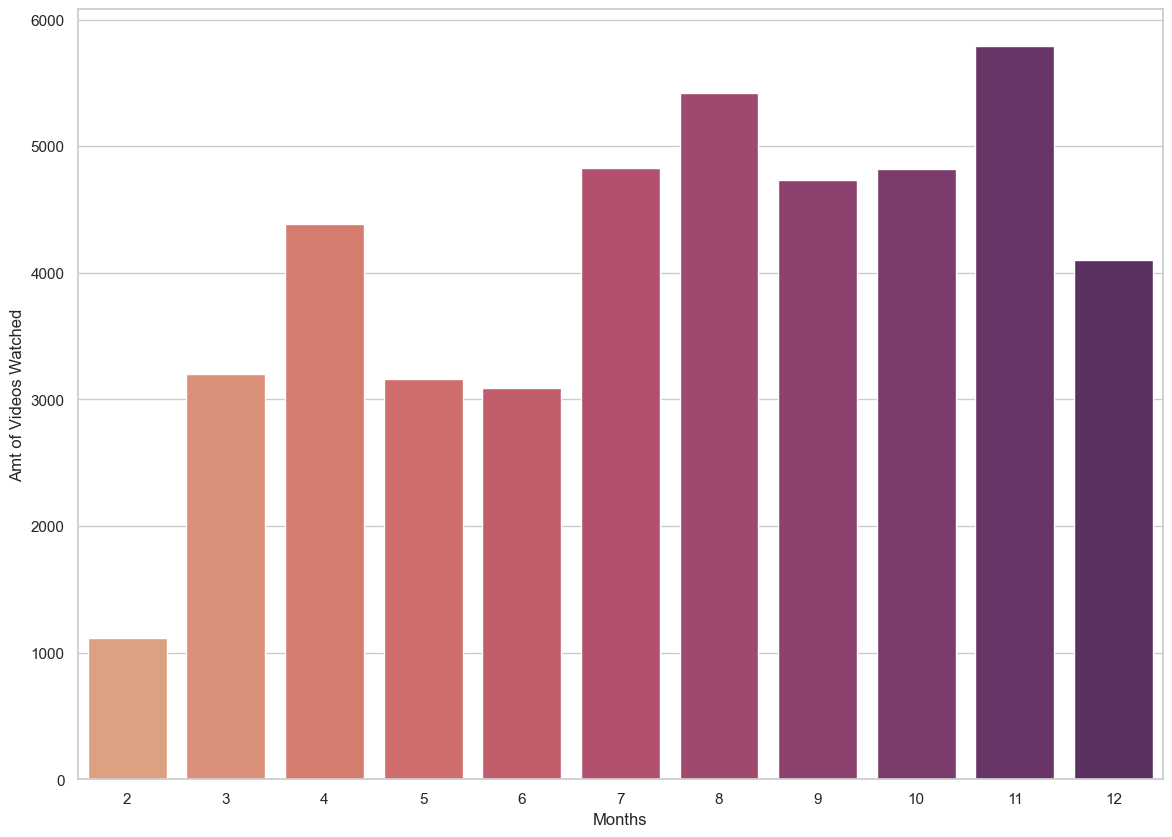

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe and it has a 'Month' column
# Group by 'Month' and count the occurrences
monthly_agg = df.groupby('Month').size().reset_index(name='count')

# Generate a color palette with the same number of colors as months
color = sns.color_palette('flare', n_colors=monthly_agg['Month'].nunique())

plt.figure(figsize=(14,10))
sns.barplot(
    x='Month', 
    y='count', 
    data=monthly_agg, 
    palette=color,
    hue='Month'  # Assign x variable to hue
)
plt.xlabel('Months')
plt.ylabel('Amt of Videos Watched')
plt.legend([],[], frameon=False)  # This removes the legend if not needed

plt.show()


In [20]:
grouped_year_month = df.groupby(['Month', 'Year'])['Month'].value_counts().reset_index()
grouped_year_month

,Month,Year,count
0,2,2023,1115
1,3,2023,3200
2,4,2023,4382
3,5,2023,3164
4,6,2023,3093
5,7,2023,4828
6,8,2023,5419
7,9,2023,4731
8,10,2023,4820
9,11,2023,5792


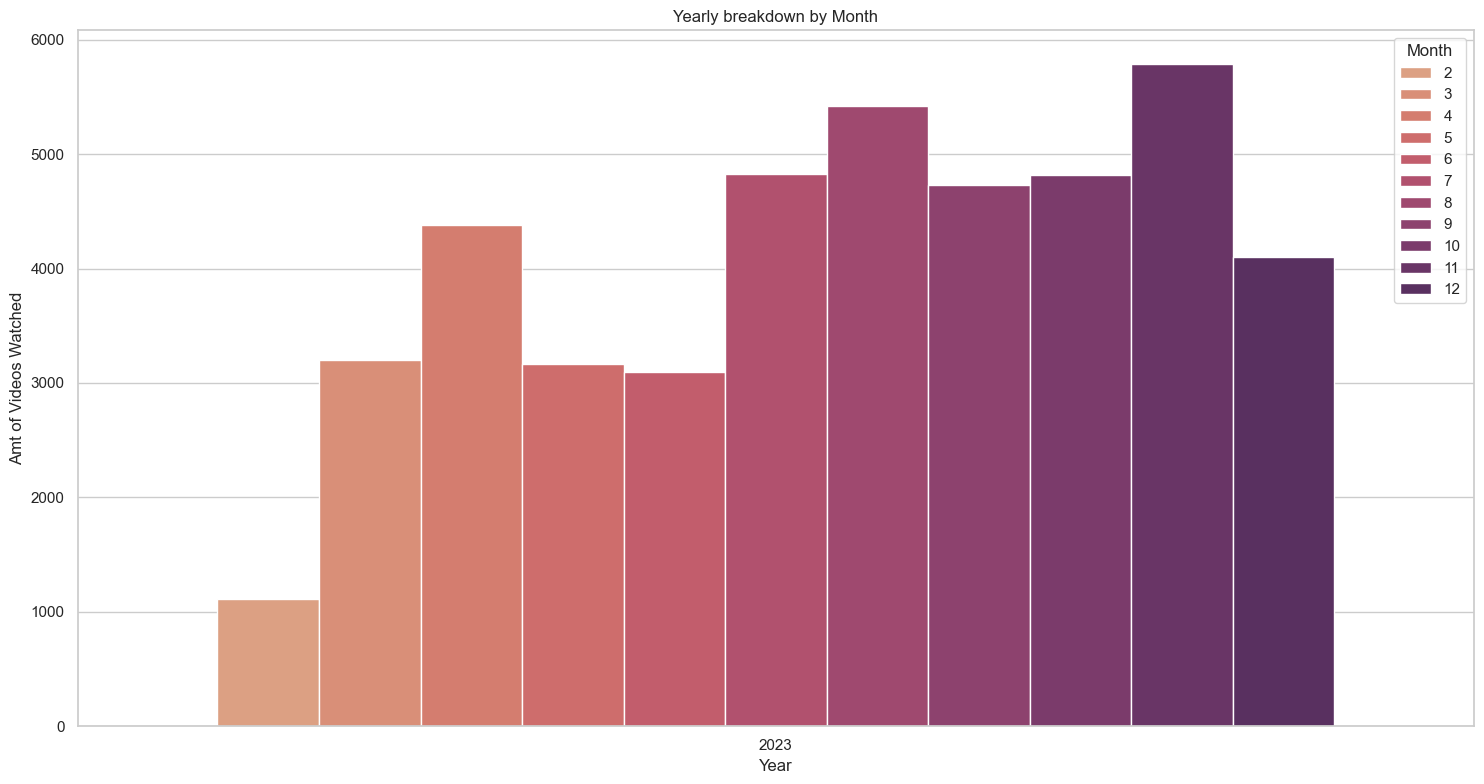

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))

custom_palette = sns.color_palette("flare", n_colors=len(grouped_year_month['Month'].unique()))

# Use seaborn's barplot to create a grouped bar chart
sns.barplot(x='Year', y='count', hue='Month', data=grouped_year_month, ax=ax, palette=custom_palette)

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Amt of Videos Watched')
ax.set_title('Yearly breakdown by Month')

ax.legend(title='Month', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

# Finding Out Which Channel I Watched From in May 2023

In [24]:
may_2023 = df[(df['Year'] == 2023) & (df['Month'] == 5)]
may_2023.groupby('Channel Name').size().reset_index(name='count').sort_values(by='count').tail(10)

,Channel Name,count
10,32.Gün,26
827,Onur Akın - Topic,29
532,Jedi Ustası,32
1073,Tancan Fümen,34
928,Ruhi Su - Topic,34
1118,TheDuelLogs,40
818,Obi-Wan TR,64
197,Can Sungur ve Yakın Evren,72
709,Mert Günhan ve Yakın Arkadaşı,114
427,Geekyapar!,154


# My Most Active Hours In A Day

C:\Users\emirm\AppData\Local\Temp\ipykernel_10460\1477023687.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour_of_day', y='count', data=hourly_breakdown, palette=color)


Text(0, 0.5, 'Amount of Videos Watched')

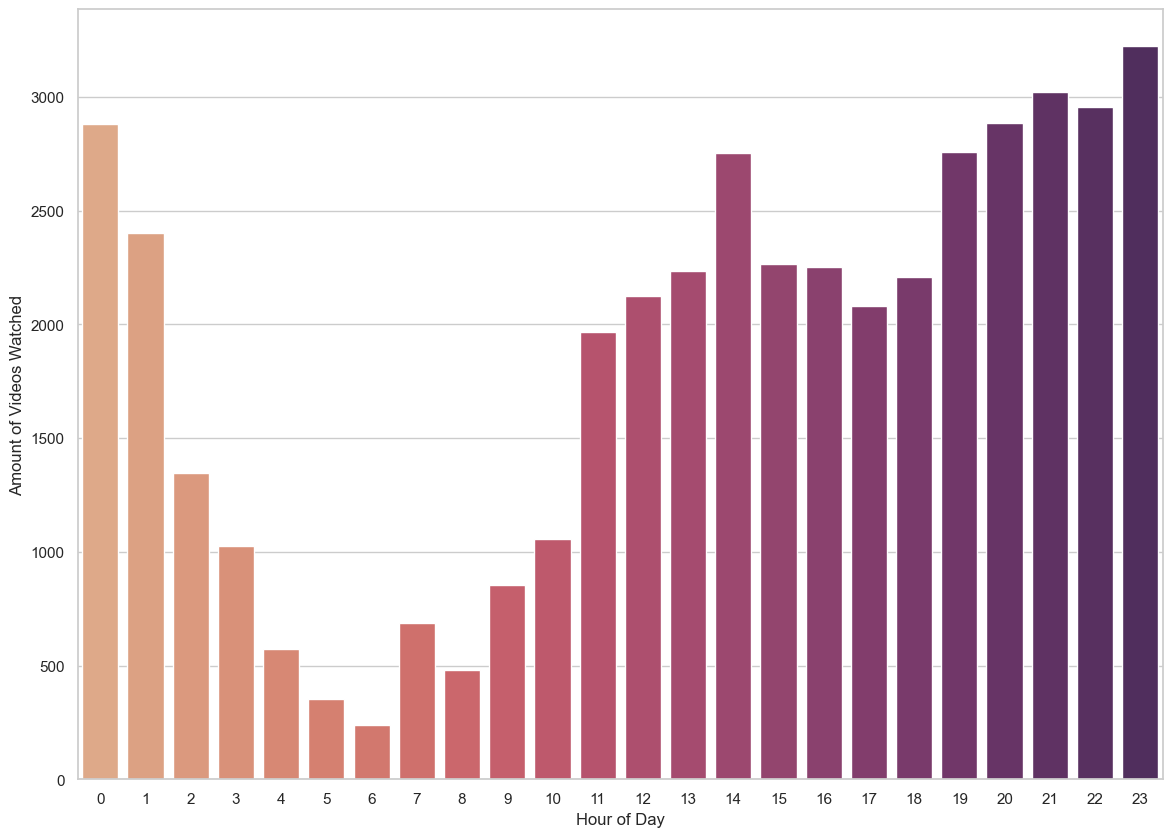

In [25]:
hourly_breakdown = df.groupby('Hour_of_day').size().reset_index(name='count')

color = sns.color_palette('flare', n_colors=len(hourly_breakdown['Hour_of_day'].unique()))

plt.figure(figsize=(14,10))
sns.barplot(x='Hour_of_day', y='count', data=hourly_breakdown, palette=color)
plt.xlabel('Hour of Day')
plt.ylabel('Amount of Videos Watched')

C:\Users\emirm\AppData\Local\Temp\ipykernel_10460\2416759946.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour_of_day', y='count', data=data, ax=ax, palette=color)
C:\Users\emirm\AppData\Local\Temp\ipykernel_10460\2416759946.py:16: UserWarning: The palette list has more values (24) than needed (22), which may not be intended.
  sns.barplot(x='Hour_of_day', y='count', data=data, ax=ax, palette=color)
C:\Users\emirm\AppData\Local\Temp\ipykernel_10460\2416759946.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour_of_day', y='count', data=data, ax=ax, palette=color)
C:\Users\emirm\AppData\Local\Temp\ipykernel_10460\2416759946.py:16: FutureWarning: 

Passing `palette` withou

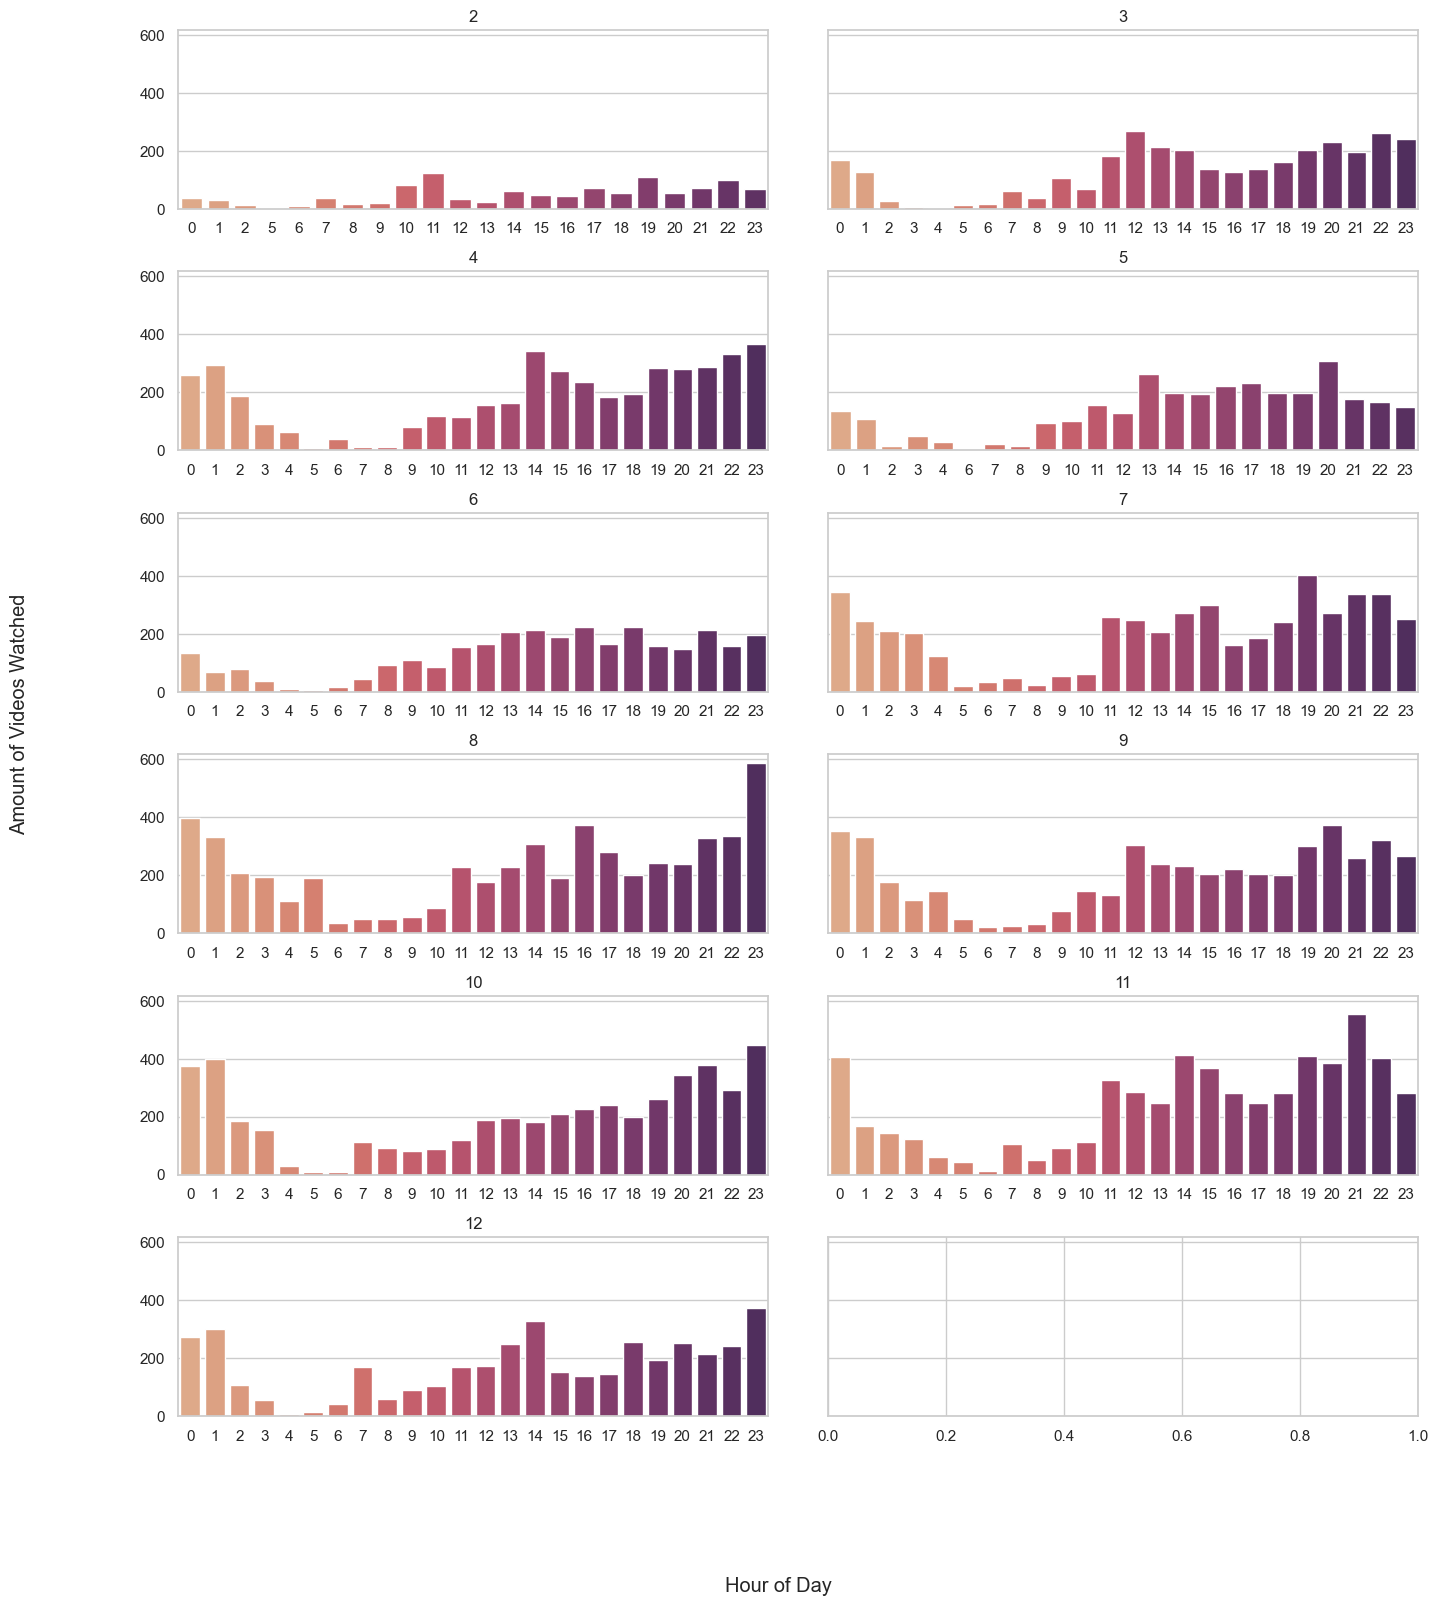

In [26]:
m_h_breakdown = df.groupby(['Month', 'Hour_of_day'])['Month'].value_counts().reset_index()

custom_palette = sns.color_palette("flare", as_cmap=True)

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16,18), sharey=True)

fig.supxlabel('Hour of Day')
fig.supylabel('Amount of Videos Watched')

# Flatten the 2D array of subplots
axes = axes.flatten()

# Loop through each month and create a subplot
for i, (month, data) in enumerate(m_h_breakdown.groupby('Month')):
    ax = axes[i]
    sns.barplot(x='Hour_of_day', y='count', data=data, ax=ax, palette=color)
    ax.set_title(month)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust layout
plt.subplots_adjust(wspace=0.1, hspace=0.35)

# Show the plot
plt.show()

# Activity by DOW

In [27]:
dow_activity = df.groupby(['Dow']).size().reset_index(name='count')
dow_activity

,Dow,count
0,0,5911
1,1,5937
2,2,6063
3,3,6086
4,4,6365
5,5,6353
6,6,7928


C:\Users\emirm\AppData\Local\Temp\ipykernel_10460\2541384019.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dow', y='count', data=dow_activity, palette=color)
C:\Users\emirm\AppData\Local\Temp\ipykernel_10460\2541384019.py:4: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Dow', y='count', data=dow_activity, palette=color)


Text(0, 0.5, 'Amount of Videos Watched')

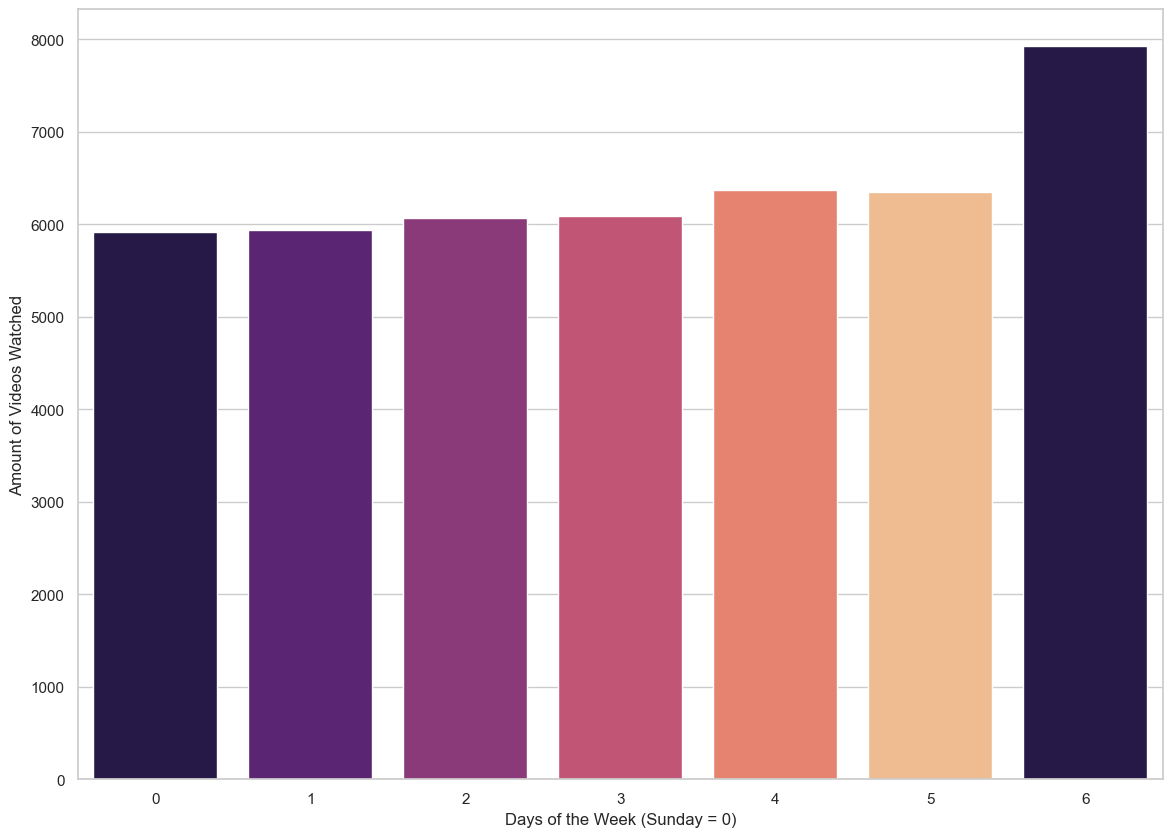

In [29]:
color = sns.color_palette('magma')

plt.figure(figsize=(14,10))
sns.barplot(x='Dow', y='count', data=dow_activity, palette=color)
plt.xlabel('Days of the Week (Sunday = 0)')
plt.ylabel('Amount of Videos Watched')

In [30]:
dow_year_activity = grouped_year_month = df.groupby(['Dow', 'Year'])['Dow'].value_counts().reset_index()

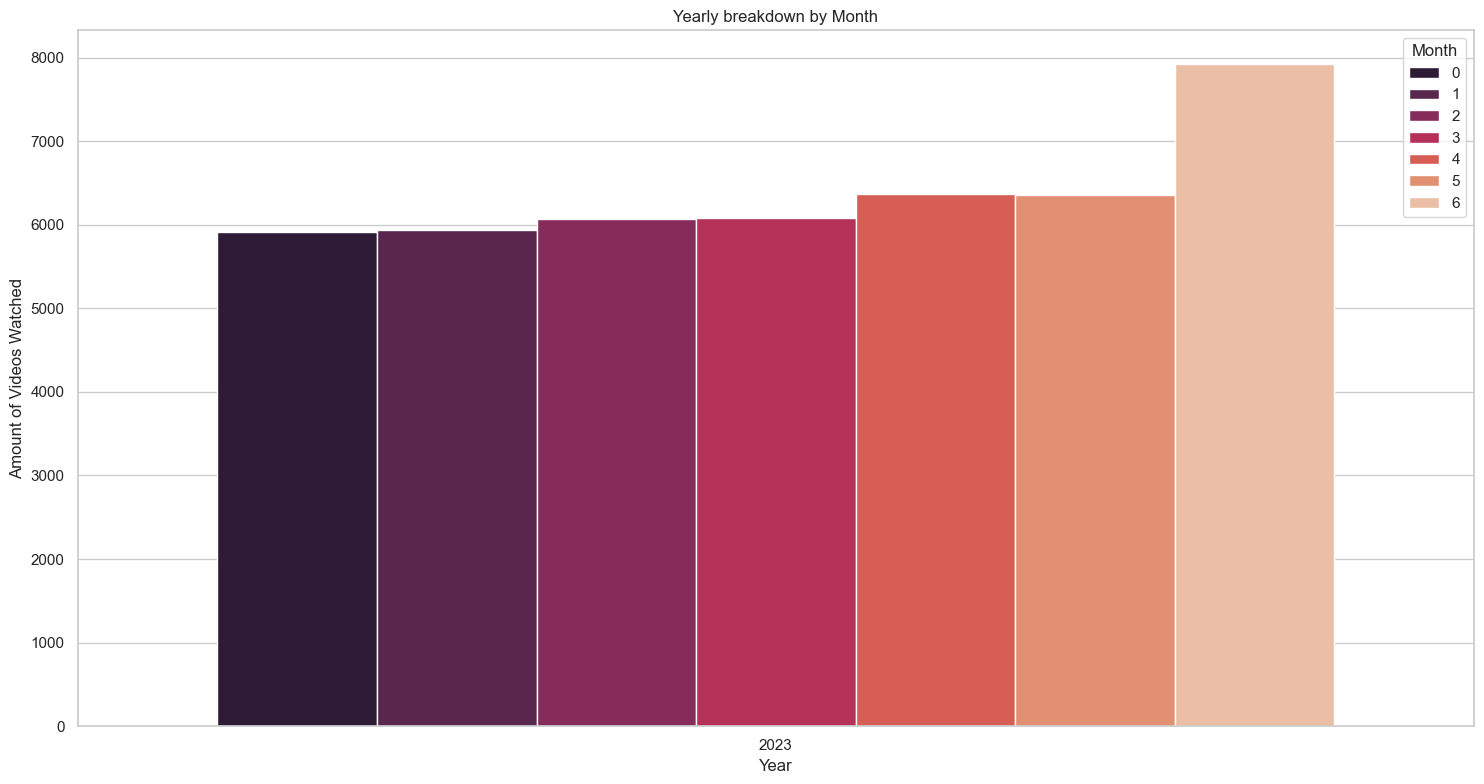

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))

custom_palette = sns.color_palette("rocket", n_colors=len(dow_year_activity['Dow'].unique()))

# Use seaborn's barplot to create a grouped bar chart
sns.barplot(x='Year', y='count', hue='Dow', data=dow_year_activity, ax=ax, palette=custom_palette)

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Amount of Videos Watched')
ax.set_title('Yearly breakdown by Month')

ax.legend(title='Month', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

# Videos I watched a day and per hour on average

In [32]:
yearly_videos = df.groupby('Year').size().reset_index(name='count')
yearly_videos['daily'] = yearly_videos['count'] / 365
yearly_videos['hourly'] = yearly_videos['daily'] / 24
yearly_videos

,Year,count,daily,hourly
0,2023,44643,122.309589,5.096233


# How many videos have I watched that are about Turkish politics?

In [40]:
keywords = ['chp', 'akp', 'darbe', 'sol', 'sağ', 'seçim',
    'mhp', 'hdp', 'demokrasi', 'cumhuriyet', 'milliyetçi', 
    'sosyalist', 'liberal', 'konservatif', 'anayasa', 'meclis', 
    'başkanlık', 'parlamento', 'referandum', 'siyaset', 'politika', 
    'devlet', 'hükümet', 'muhalefet', 'parti', 'politik', 'seçmen', 
    'sandık', 'oy', 'kampanya', 'miting', 'lider', 'genel seçim', 
    'yerel seçim', 'anayasa değişikliği', 'ulusal', 'yerel', 'kürt', 
    'laik', 'laiklik', 'adalet', 'özgürlük', 'eşitlik', '32. gün', 'erdoğan', 'kılıçdaroğlu']
regex_pattern = '|'.join(keywords)  

politics_videos = df[df['Video Title'].str.contains(regex_pattern, case=False, na=False)]
print(politics_videos.shape[0])


5405


In [41]:
politics_videos.groupby('Channel Name').size().reset_index(name='count').sort_values(by='count').tail()

,Channel Name,count
377,Emin Çıtak,91
790,Mert Günhan ve Yakın Arkadaşı,165
1128,Tancan Fümen,195
232,Can Sungur ve Yakın Evren,237
8,32.Gün,610


# Most frequent terms in video titles

In [42]:
# Split the title into a list for each row
df['Video Title Tags'] = df['Video Title'].apply(lambda x: x.split())  

# Flatten the lists in the column
flat_list = [item for sublist in df['Video Title Tags'] for item in sublist]

In [43]:
# Create the DataFrame object with these tags and counts of each
word_counts = pd.DataFrame({'tags':flat_list}).value_counts().reset_index()

In [55]:
# Exclude tags '#keşfet' and '#shorts' and also apply the length filter
excluded_tags = ['#keşfet', '#shorts']
title_tags = word_counts[(~word_counts['tags'].isin(excluded_tags)) & (word_counts['tags'].str.len() > 4)].sort_values(by='count')

# Display the last 10 tags
title_tags.tail(10)


,tags,count
42,Belgeseli,465
41,WIRED,468
40,Atatürk,470
38,Elden,477
37,Pokemon,479
31,Sungur,549
28,Marşı,618
17,Arşivi,729
15,Souls,835
8,Bölüm,1134


# Political Leanings

In [50]:
import pandas as pd

# Load your YouTube watch history data
youtube_df = pd.read_csv('D:/Downloads/youtube_history.csv')

# Define keywords for different political ideologies in Turkish
left_wing_keywords = [
    'sol', 'ilerici', 'sosyalist', 'chp', 'hdp', 'tkp', 'tip', 'eşitlik', 'özgürlük',
    'laik', 'laiklik', 'barış', 'aktivist', 'sendika', 'emek',
    'antikapitalist', 'feminist', 'ekoloji', 'sivil haklar', 'azınlık hakları'
]

right_wing_keywords = [
    'sağ', 'muhafazakar', 'milliyetçi', 'akp', 'mhp', 'ülkücü',
    'milli', 'geleneksel', 'dindar', 'islamcı', 'konservatif', 'ulusalcı', 
    'lider', 'otoriter', 'hükümet', 'ulus devlet'
]



# Function to categorize a video based on keywords
def categorize_video(title):
    if isinstance(title, str):
        title_lower = title.lower()  # Convert title to lowercase for case-insensitive matching
        for word in left_wing_keywords:
            if word in title_lower:
                return 'Left-Wing Videos'
        for word in right_wing_keywords:
            if word in title_lower:
                return 'Right-Wing Videos'

    return 'Kategorisiz'  # Uncategorized for non-string or missing titles

# Categorize each video
youtube_df['Siyasi Eğilim'] = youtube_df['Video Title'].apply(categorize_video)

# Filter out 'Kategorisiz' before calculating value counts
filtered_df = youtube_df[youtube_df['Siyasi Eğilim'] != 'Kategorisiz']

# Analyze the results
political_distribution = filtered_df['Siyasi Eğilim'].value_counts()

# Output the results
print(political_distribution)

Siyasi Eğilim
Left-Wing Videos     1201
Right-Wing Videos     466
Name: count, dtype: int64


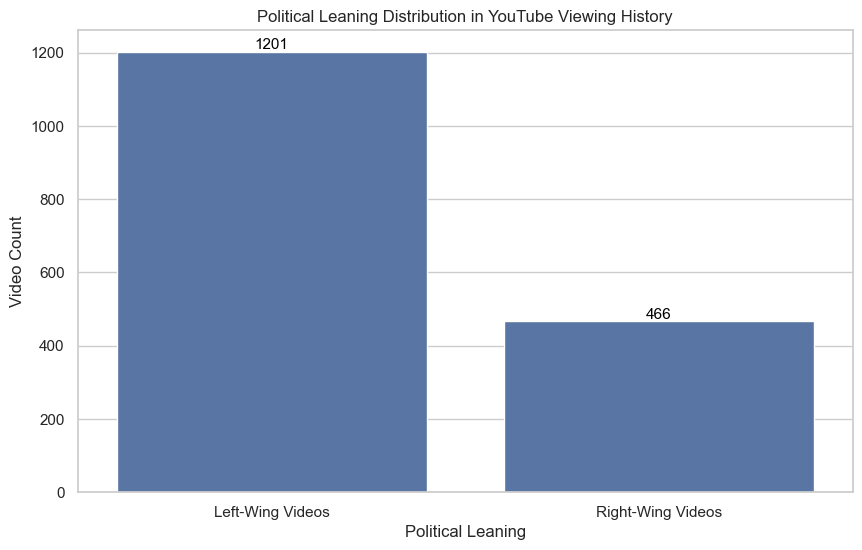

In [67]:
# Categorize each video
youtube_df['Siyasi Eğilim'] = youtube_df['Video Title'].apply(categorize_video)

# Analyze the results
political_distribution = youtube_df['Siyasi Eğilim'].value_counts()
political_distribution = political_distribution[political_distribution.index != 'Kategorisiz']
# Start plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create the bar plot
ax = sns.barplot(x=political_distribution.index, y=political_distribution.values)

# Add the text with the count on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set the title and labels
plt.title('Political Leaning Distribution in YouTube Viewing History')
plt.xlabel('Political Leaning')
plt.ylabel('Video Count')

# Show the plot
plt.show()

# WordCloud

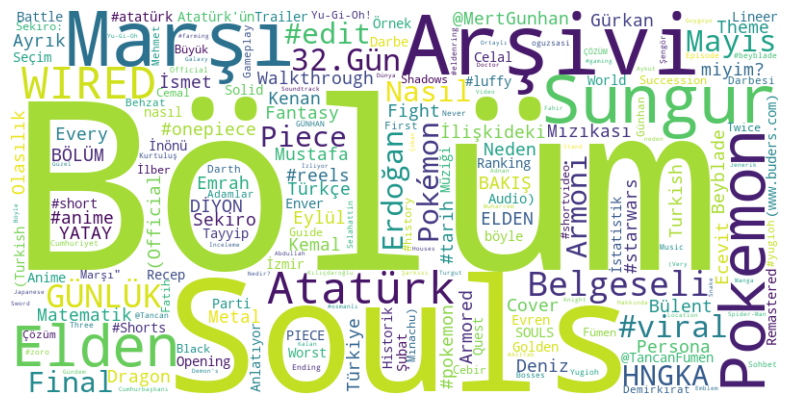

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Exclude tags '#keşfet' and '#shorts'
excluded_tags = ['#keşfet', '#shorts']
filtered_title_tags = title_tags[~title_tags['tags'].isin(excluded_tags)]

# Generate a WordCloud using the filtered data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_title_tags.set_index('tags')['count'])

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
